<div>
<img src="svtLogo.png"/>
</div>
<h1><center>Mathematical Optimization for Engineers</center></h1>
<h2><center>Lab 12 - Direct single shooting</center></h2>

In this exercise, we want to solve the van der Pol oscillator optimal control problem using the direct single shooting approach. 
The problem without state constraints is as follows: 
$\begin{align}
\min_{u(t)} \int_{t_{0}}^{t_{f}} x_1^2(t) + x_2^{2}(t) + u(t)^2 dt\\
s.t.  \dot{x} = f(x(t),u(t))\\
x(t_{0}) = x_{0} \\
u_{lb} \leq u(t) \leq u_{ub}\\
\end{align}
$

For direct single shooting, the differential equations are solved by an integration scheme, which is needed to be set-up. 


In [1]:
import numpy as np

from scipy.integrate import odeint, solve_ivp

from scipy.optimize import fmin,fmin_bfgs, Bounds, minimize, NonlinearConstraint

from matplotlib import pyplot as plt
from matplotlib import animation

In [2]:
def eval_rhs(t, x, u, p):

    f = np.zeros(3)
    
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    
    f[0] = (1-x2**2)*x1 - x2 + u
    f[1] = x1
    f[2] = x1**2 + x2**2 + u**2
    
    return f

In [3]:
def objective_ode_integration(p, func, x0, finalTime, output_state,
                              is_path_constraint, doPlot):
    # inputs are as follows
    # p = parameter vector of control discretization
    # func: right-hand side of ODE f(t, x, u, p)
    # x0 = initial condition
    # finalTime = tN
    # doPlot = boolean variable, if true, plot solution   

    N = len(p) # Number of discretization intervals
    h = finalTime /N # length of a single interval
    n_x = len(x0)  # number of states
    x0_cur = x0
    y_all = np.array([x0]).transpose() 
    t_all = np.array([0])
    output = list()

    for i in range(N): # loop over discretization intervals
        # solve initial value problem
        sol = solve_ivp(func, t_span=[i * h, (i + 1) * h], y0=x0_cur, t_eval=np.linspace(i*h, (i+1)*h, 100), args=(p[i], 0.0))
        y = sol.y
        # update initial conditions
        x0_cur = y[0:n_x, -1]

        y_all = np.concatenate((y_all, sol.y), axis=1)
        t_all = np.concatenate((t_all, sol.t), axis=0)
        output.append(y[output_state, -1])



    if doPlot:
        y_all = np.array(y_all)
        plt.subplot(221)
        plt.plot(t_all, y_all[0, :])
        plt.title('x1')

        plt.subplot(222)
        plt.plot(t_all, y_all[1, :])
        plt.title('x2')

        plt.subplot(223)
        plt.plot(t_all, y_all[2, :])
        plt.title('x3')
        #
        plt.subplot(224)
        plt.plot(np.linspace(0, finalTime, N), p)
        plt.title('u')

        plt.tight_layout()
        plt.show()
        
    if not is_path_constraint: 
        output = output[-1]
    else:
        # constraint hard coded here to allow for 
        # constraint definition with arguments
        # in scipy, c(x) >= 0
        output = np.array(output) + 0.4

    return output

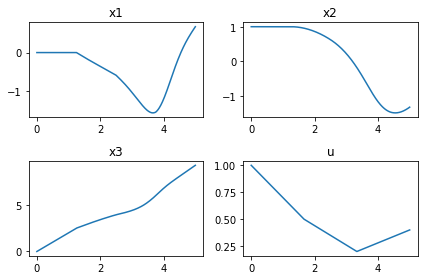

array([], dtype=float64)

In [4]:
objective_ode_integration([1.0, 0.5, 0.2, 0.4], eval_rhs, [0, 1, 0], 5, [], [], True)

  NIT    FC           OBJFUN            GNORM
    1    27     1.766199E+01     4.577415E+00
    2    54     1.344023E+01     1.042211E+01
    3    81     5.727325E+00     4.976972E+00
    4   107     3.218451E+00     5.338511E+00
    5   133     2.963698E+00     2.985405E+00
    6   159     2.888169E+00     1.820170E+00
    7   185     2.878646E+00     2.644443E-01
    8   211     2.877279E+00     1.900922E-01
    9   237     2.876331E+00     2.101674E-01
   10   263     2.876315E+00     1.153516E-02
   11   289     2.876312E+00     1.148526E-02
   12   314     2.876312E+00     1.232325E-02
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8763115967809894
            Iterations: 12
            Function evaluations: 314
            Gradient evaluations: 12


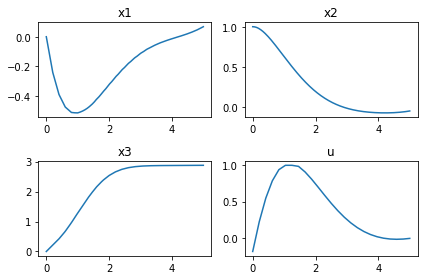

array([], dtype=float64)

In [5]:
finalTime = 5
N = 25 # Number of discretization intervals for the control
doPlot = False
p0 = 1.0*np.ones(N) # initial guess for optimization
x0 = [0, 1, 0]

bnds = Bounds(-0.3, 1.0)

output_state = 2  # for objective
is_path_constraint = False
solDO = minimize(objective_ode_integration, p0, \
             args=(eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot), 
              bounds = bnds, method='SLSQP', jac=None, 
                 options={'iprint':3, 'disp': True})
objective_ode_integration(solDO.x, eval_rhs, [0, 1, 0], 5, [], [], True)


## Adding state path constraint
After solvindg the problem without state constraints, we want to include the path constraint on the state $x_1$:
$ \begin{align}
x_1(t) \geq - 0.4 \forall t \in [t_{0},t_{f}]
\end{align}$
For this task, we must add this constraint to the optimization problem. One way is to define the constraint function as constraint dictionary in Python. 

  NIT    FC           OBJFUN            GNORM
    1    27     9.119465E+00     4.577415E+00
    2    54     3.007179E+00     1.926100E+00
    3    80     3.120862E+00     1.418164E+00
    4   107     2.966474E+00     8.705953E-01
    5   133     2.964156E+00     8.048974E-01
    6   159     2.964164E+00     7.656755E-01
    7   186     2.963848E+00     8.371402E-01
    8   212     2.963837E+00     7.971808E-01
    9   237     2.963837E+00     8.035592E-01
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9638372553573062
            Iterations: 9
            Function evaluations: 237
            Gradient evaluations: 9


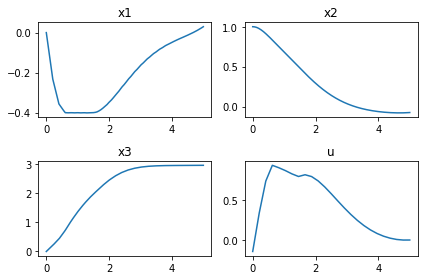

array([], dtype=float64)

In [6]:
# in scipy, the inequality constraints are defined as
# c(x) >= 0 
cons = ({'type': 'ineq',
       'fun': objective_ode_integration,
       'args': (eval_rhs, x0, finalTime, 0, True, False)       
       })
output_state = 2  # for objective
is_path_constraint = False
solDO = minimize(objective_ode_integration, p0, \
             args=(eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot), 
              bounds = bnds, method='SLSQP', jac=None, constraints=cons, 
                 options={'iprint':3, 'disp': True})

objective_ode_integration(solDO.x, eval_rhs, [0, 1, 0], 5, [], [], True)


## What could be made more efficient for this optimization? 

Currently, the dynamic system is integrated both for the objective and the constraints separately. In a more efficient implementation, the information gained by the integration would be used for both the constraints and the objective.